In [1]:
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from pydantic import Field
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from typing import Annotated, List
import operator
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send
from IPython.display import Markdown, Image

from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [3]:
class SharedState(TypedDict):
    research_topic: str
    model: ChatOpenAI
    sections: list[Section]
    section_contents: Annotated[list[str], operator.add]
    final_report: str

In [4]:
def build_model(shared_state: SharedState) -> SharedState:
    shared_state['model'] = ChatOpenAI(model="gpt-4o", temperature=0)
    return shared_state

In [5]:
def orchestrator(shared_state: SharedState) -> SharedState:
    model = shared_state['model']
    orchestrator_prompt = ChatPromptTemplate.from_template(
        "Create a detailed outline for a research report on the topic of {research_topic}. "
        "Break the report down into sections, each with a name and brief description. "
        "Limit the report to at max 5 sections."
    )

    model_with_structured_output = model.with_structured_output(Sections)
    retrieval_grader = orchestrator_prompt | model_with_structured_output
    result = retrieval_grader.invoke(
        {
            "research_topic": shared_state['research_topic'],
        }
    )
    shared_state['sections'] = [section for section in result.sections]

    return shared_state


In [6]:
load_dotenv()

shared_state = build_model({'research_topic': 'The impact of AI on modern education.'})
shared_state = orchestrator(shared_state)

shared_state['sections']

[Section(name='Introduction', description='This section will provide an overview of the research topic, including the definition of AI and its relevance in the context of modern education. It will also outline the objectives and significance of the study.'),
 Section(name='Historical Context and Evolution of AI in Education', description='This section will explore the historical development of AI technologies and their integration into educational systems. It will cover key milestones and the evolution of AI applications in education over the years.'),
 Section(name='Current Applications of AI in Education', description='This section will delve into the various ways AI is currently being utilized in educational settings. It will cover AI-driven tools and platforms, personalized learning experiences, and administrative applications that enhance educational processes.'),
 Section(name='Challenges and Ethical Considerations', description='This section will address the challenges and ethic

In [7]:
# Worker state
class WorkerState(TypedDict):
    section: Section
    model: ChatOpenAI
    completed_sections: Annotated[list, operator.add]

In [9]:
def worker(worker_state: WorkerState) -> SharedState:
    """Worker writes a section of the report"""
    print(f"\nWorker Spawned! Working on section: {worker_state['section'].name}")
    model = worker_state['model']
    section = worker_state['section']
    # Generate section
    section = model.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"section_contents": [section.content]}


In [10]:
# Conditional edge function to create llm_call workers that each write a section of the report
def spawn_workers(shared_state: SharedState):
    """Assign a worker to each section in the plan"""
    model = shared_state["model"]
    # Kick off section writing in parallel via Send() API
    return [
        Send("worker", {"section": section, "model": model}) 
        for section in shared_state["sections"]
    ]

In [11]:
def synthesizer(shared_state: SharedState):
    """Synthesize full report from sections"""

    # List of completed sections
    section_contents = shared_state["section_contents"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(section_contents)

    return {"final_report": completed_report_sections}


In [12]:
def build_workflow():
    # Build workflow
    orchestrator_worker_builder = StateGraph(SharedState)

    # Add the nodes
    orchestrator_worker_builder.add_node("build_model", build_model)
    orchestrator_worker_builder.add_node("orchestrator", orchestrator)
    orchestrator_worker_builder.add_node("worker", worker)
    orchestrator_worker_builder.add_node("synthesizer", synthesizer)

    # Add edges to connect nodes
    orchestrator_worker_builder.add_edge(START, "build_model")
    orchestrator_worker_builder.add_edge("build_model", "orchestrator")
    orchestrator_worker_builder.add_conditional_edges(
        "orchestrator", spawn_workers, ["worker"]
    )
    orchestrator_worker_builder.add_edge("worker", "synthesizer")
    orchestrator_worker_builder.add_edge("synthesizer", END)

    # Compile the workflow
    return orchestrator_worker_builder.compile()

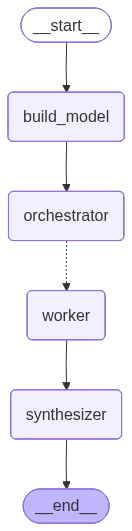

In [13]:
orchestrator_worker = build_workflow()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [14]:
state = orchestrator_worker.invoke({"research_topic": "How to prepare for a System Design technical Interview?"})

Markdown(state["final_report"])


Worker Spawned! Working on section: Understanding Core Concepts
Worker Spawned! Working on section: Introduction to System Design Interviews

Worker Spawned! Working on section: Preparation Strategies


Worker Spawned! Working on section: Common System Design Problems

Worker Spawned! Working on section: Mock Interviews and Feedback


## Introduction to System Design Interviews

System design interviews are a critical component of the technical hiring process, particularly for roles that require designing scalable and efficient systems. These interviews are designed to evaluate a candidate's ability to architect complex systems, demonstrating their understanding of both high-level design principles and the practical considerations necessary for building robust, scalable solutions.

### Importance in the Tech Industry

In the tech industry, the ability to design systems that can handle large volumes of data and traffic is crucial. As companies grow, the demand for systems that can scale efficiently becomes paramount. System design interviews help employers identify candidates who possess the necessary skills to meet these challenges. They assess a candidate's ability to think critically about system architecture, make informed trade-offs, and apply best practices in software engineering.

### Skills Assessed

System design interviews evaluate a range of skills, including:

- **Architectural Thinking**: The ability to conceptualize and articulate a high-level architecture that meets the requirements of a given problem.
- **Scalability and Performance**: Understanding how to design systems that can scale efficiently and maintain performance under load.
- **Problem Solving**: The capacity to break down complex problems into manageable components and devise effective solutions.
- **Communication**: The ability to clearly explain design choices and thought processes to interviewers, often involving collaboration and iterative feedback.
- **Knowledge of Technologies**: Familiarity with various technologies, tools, and frameworks that can be leveraged to build effective systems.

### Typical Format

System design interviews typically follow a structured format, where candidates are presented with a problem statement and asked to design a system that addresses the requirements. The interview usually begins with a discussion to clarify the problem and gather requirements. Candidates are expected to:

1. **Clarify Requirements**: Ask questions to ensure a clear understanding of the problem and any constraints.
2. **Outline the High-Level Design**: Present an initial design, often using diagrams to illustrate the architecture.
3. **Discuss Trade-offs**: Explain the reasoning behind design choices, considering factors like scalability, reliability, and cost.
4. **Iterate and Refine**: Respond to feedback from interviewers, refining the design to address any identified issues or additional requirements.

### Expectations from Candidates

Candidates are expected to demonstrate a methodical approach to problem-solving, showcasing their ability to design systems that are not only functional but also efficient and scalable. They should be prepared to engage in a dialogue with interviewers, justifying their design decisions and adapting to new information or constraints as the interview progresses. Ultimately, the goal is to exhibit a deep understanding of system design principles and the ability to apply them effectively in real-world scenarios.

---

## Understanding Core Concepts

In the realm of system design interviews, grasping the fundamental concepts and principles is essential for crafting robust and efficient systems. This section explores the core concepts that form the backbone of system design, including scalability, reliability, availability, and performance. Additionally, it highlights the significance of understanding trade-offs and constraints, which are pivotal in making informed design decisions.

### Scalability

Scalability refers to a system's ability to handle increased load without compromising performance. It is a critical consideration in system design, especially for applications expected to grow over time. Scalability can be achieved through vertical scaling (adding more resources to a single node) or horizontal scaling (adding more nodes to a system). Understanding the differences and applications of these scaling strategies is vital for designing systems that can efficiently manage growth.

### Reliability

Reliability is the measure of a system's ability to function correctly and consistently over time. It involves ensuring that the system can recover from failures and continue to operate as expected. Designing for reliability often includes implementing redundancy, failover mechanisms, and regular testing to identify and mitigate potential points of failure. A reliable system minimizes downtime and maintains user trust.

### Availability

Availability is the degree to which a system is operational and accessible when required for use. It is often expressed as a percentage of uptime over a given period. High availability systems are designed to minimize downtime and ensure that services are always accessible to users. Techniques such as load balancing, data replication, and geographic distribution of resources are commonly employed to enhance availability.

### Performance

Performance in system design refers to the system's ability to respond to requests within an acceptable time frame. It encompasses various aspects, including latency, throughput, and resource utilization. Optimizing performance involves identifying bottlenecks, optimizing algorithms, and ensuring efficient resource management. A well-performing system provides a seamless user experience and can handle peak loads effectively.

### Trade-offs and Constraints

Understanding trade-offs and constraints is crucial in system design, as they influence the decisions made during the design process. Trade-offs often involve balancing competing priorities, such as cost versus performance or scalability versus complexity. Constraints can include budget limitations, technological restrictions, or specific business requirements. Recognizing these factors allows designers to make informed choices that align with the overall goals and limitations of the project.

In summary, mastering these core concepts is essential for success in system design interviews. By understanding scalability, reliability, availability, and performance, and by considering trade-offs and constraints, candidates can design systems that are not only functional but also efficient and resilient.

---

## Preparation Strategies

Preparing for system design interviews requires a strategic approach that combines theoretical knowledge with practical application. This section outlines effective strategies to help candidates excel in these interviews by leveraging various resources and understanding real-world systems.

### Resources for System Design Preparation

1. **Books**: 
   - *Designing Data-Intensive Applications* by Martin Kleppmann: This book provides a comprehensive overview of the principles behind scalable and maintainable systems.
   - *System Design Interview – An Insider's Guide* by Alex Xu: A popular resource that offers insights into common system design interview questions and solutions.
   - *The Art of Scalability* by Martin L. Abbott and Michael T. Fisher: This book covers the principles of building scalable systems, which is crucial for system design interviews.

2. **Online Courses**:
   - **Coursera**: Courses like "Scalable Web Applications" and "Cloud Computing Concepts" provide foundational knowledge in system design.
   - **Udemy**: Offers courses specifically tailored for system design interviews, focusing on practical examples and case studies.
   - **Educative.io**: Known for its interactive courses, Educative offers a "Grokking the System Design Interview" course that is highly recommended for its structured approach.

3. **Practice Problems**:
   - **LeetCode**: While primarily known for coding problems, LeetCode also offers system design questions that can help in practicing interview scenarios.
   - **Pramp**: Provides peer-to-peer mock interviews, including system design sessions, which are invaluable for real-time feedback.
   - **Exercism**: Offers exercises that can help in understanding different system components and their interactions.

### Understanding Real-World Systems

To excel in system design interviews, it is crucial to understand how real-world systems operate. This involves:

- **Analyzing Existing Systems**: Study the architecture of well-known systems like Google, Facebook, or Amazon. Understand how they handle scalability, reliability, and performance.
- **Case Studies**: Engage with case studies that detail the design decisions behind successful systems. This can provide insights into the trade-offs and considerations involved in system design.
- **Open Source Projects**: Contributing to or studying open-source projects can offer practical experience in system design and implementation.

### Approaching Learning from Real-World Systems

1. **Reverse Engineering**: Try to deconstruct existing systems to understand their components and how they interact. This can be done by reading technical blogs, whitepapers, or documentation.
2. **Networking with Professionals**: Engage with professionals in the field through platforms like LinkedIn or industry meetups. Discussions with experienced engineers can provide valuable insights into system design.
3. **Hands-On Projects**: Build your own projects that mimic real-world systems. This hands-on experience is invaluable for understanding the complexities and challenges of system design.

By combining these resources and strategies, candidates can develop a robust understanding of system design principles and be well-prepared for interviews. The key is to balance theoretical knowledge with practical application, ensuring a comprehensive preparation approach.

---

### Common System Design Problems

In technical interviews, system design problems are a staple, challenging candidates to demonstrate their ability to architect scalable and efficient systems. This section delves into some of the most frequently encountered system design problems, providing insights into typical questions and offering a structured approach to solving them.

#### Typical System Design Questions

1. **Design a URL Shortening Service**
   - **Problem Statement**: Create a service like Bitly that converts long URLs into shorter, more manageable links.
   - **Key Considerations**:
     - **Scalability**: The system should handle a large number of requests and store billions of URLs.
     - **Uniqueness**: Ensure that each short URL is unique.
     - **Redirection**: Efficiently redirect users from the short URL to the original URL.
     - **Analytics**: Optionally, track the number of clicks on each short URL.

2. **Design a Social Media Platform**
   - **Problem Statement**: Architect a platform similar to Facebook or Twitter where users can post updates, follow others, and interact with content.
   - **Key Considerations**:
     - **User Profiles**: Design a scalable way to store and retrieve user information.
     - **News Feed**: Efficiently generate a personalized feed for each user.
     - **Scalability**: Handle millions of users and their interactions.
     - **Data Consistency**: Ensure data consistency across distributed systems.

3. **Design an Online Marketplace**
   - **Problem Statement**: Build a platform like eBay or Amazon where buyers and sellers can interact.
   - **Key Considerations**:
     - **Product Listings**: Efficiently manage and search through a vast number of product listings.
     - **Transactions**: Securely handle transactions between buyers and sellers.
     - **User Reviews**: Implement a reliable review and rating system.
     - **Scalability**: Support a large number of concurrent users and transactions.

#### Methodical Approach to Solving System Design Problems

1. **Clarify Requirements**: Begin by asking clarifying questions to fully understand the problem scope and constraints. Determine the core functionalities and any additional features that might be required.

2. **Define System Components**: Break down the system into major components and services. For example, in a URL shortening service, components might include a database for storing URLs, a service for generating short URLs, and a redirection service.

3. **Design Data Models**: Identify the data entities and their relationships. For instance, in a social media platform, consider user profiles, posts, comments, and likes.

4. **Architect the System**: Sketch a high-level architecture diagram. Decide on the technologies and frameworks to use, considering factors like scalability, reliability, and performance.

5. **Consider Scalability and Reliability**: Discuss how the system can scale to handle increased load and ensure high availability. Consider using load balancers, caching strategies, and database sharding.

6. **Address Security and Privacy**: Identify potential security risks and privacy concerns. Implement measures such as encryption, authentication, and access controls.

7. **Evaluate Trade-offs**: Discuss the trade-offs involved in your design decisions, such as consistency vs. availability or latency vs. throughput.

By following this structured approach, candidates can effectively tackle system design problems, demonstrating their ability to think critically and design robust systems.

---

## Mock Interviews and Feedback

Mock interviews are a crucial component of effective interview preparation, offering a simulated environment to practice and refine your skills. Engaging in mock interviews allows candidates to experience the dynamics of an interview setting, helping to alleviate anxiety and build confidence. This section will explore the significance of mock interviews, provide guidance on conducting them effectively, and highlight the role of feedback in enhancing interview performance.

### Importance of Mock Interviews

Mock interviews serve as a rehearsal for the real thing, providing an opportunity to practice responses to common interview questions, refine communication skills, and develop a professional demeanor. They help identify areas of strength and weakness, allowing candidates to focus their preparation efforts more effectively. By simulating the pressure and unpredictability of actual interviews, mock interviews help candidates become more comfortable and adaptable, ultimately leading to improved performance.

### Conducting Effective Mock Interviews

To maximize the benefits of mock interviews, consider the following tips:

1. **Simulate Real Conditions**: Conduct mock interviews in a setting that closely resembles the actual interview environment. This includes dressing appropriately, using video conferencing tools if applicable, and adhering to time constraints.

2. **Prepare a Variety of Questions**: Include a mix of behavioral, technical, and situational questions relevant to the position. This diversity will help you practice articulating your thoughts clearly and concisely across different types of inquiries.

3. **Role Play with a Partner**: Engage a friend, mentor, or career coach to act as the interviewer. This external perspective can provide valuable insights and make the experience more realistic.

4. **Record and Review**: If possible, record the mock interview session. Reviewing the footage can help identify non-verbal cues, such as body language and eye contact, that may need improvement.

5. **Focus on Key Competencies**: Tailor your practice to emphasize the skills and experiences most relevant to the job. This targeted approach ensures that you are well-prepared to discuss your qualifications effectively.

### Incorporating Feedback

Feedback is an essential element of the mock interview process, offering constructive criticism and guidance for improvement. Here’s how to effectively incorporate feedback:

1. **Seek Honest and Constructive Feedback**: Encourage your mock interviewer to provide candid feedback on your performance, focusing on both strengths and areas for improvement.

2. **Reflect on Feedback**: Take time to reflect on the feedback received, identifying patterns or recurring themes that may indicate areas needing attention.

3. **Develop an Action Plan**: Create a plan to address the feedback, setting specific goals for improvement. This might include practicing certain types of questions, enhancing communication skills, or refining your storytelling techniques.

4. **Iterate and Improve**: Use subsequent mock interviews to implement changes and track progress. Continuous practice and feedback loops are key to honing your interview skills.

By diligently practicing through mock interviews and actively seeking feedback, candidates can significantly enhance their readiness for actual interviews. This preparation not only boosts confidence but also equips candidates with the skills necessary to make a positive impression on potential employers.